# SiPM calibration

Notebook to do the SiPM calibration, using as fitting hypothesis: poisson + n gaussian

Parts:

* Read Histograms
* Calculate calbibration parameters
  * Store them into csv and hdf5
  * Produce pdf files with the relevant figures
* Identify sensors on the tail and produce plots of its distributions
* Compare with the parameters in the DB

author: Jose A. Hernando
version: v01 

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

### Revision

In [3]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

22/11/2016   14:48:06


### Dependencies

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import tables
import pandas as pd
import time

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [7]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC:/Users/hernando/Software/root/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC:/Users/hernando/Software/lib:/Users/hernando/Software/lib


### DB  

In [8]:
import Database.loadDB as db

sipmdb = db.DataSiPM()
sipmdb[:10]

sensorID  active      x      y  adc_to_pes  noise_rms
0      1000       1 -235.0   45.0     16.6974        0.0
1      1001       1 -235.0   55.0     15.9397        0.0
2      1002       1 -235.0   65.0     17.6442        0.0
3      1003       1 -235.0   75.0     16.4338        0.0
4      1004       1 -235.0   85.0     17.3464        0.0
5      1005       1 -235.0   95.0     17.0949        0.0
6      1006       1 -235.0  105.0     15.6702        0.0
7      1007       1 -235.0  115.0     15.8094        0.0
8      1008       1 -225.0   45.0     16.4761        0.0
9      1009       1 -225.0   55.0     16.5684        0.0

In [9]:
def sipm_position_of_sensorid(senid):
    dat = sipmdb[sipmdb['sensorID'] == senid]
    x, y = -200., -200.
    if (len(dat) == 1):
        x = float(dat['x'])
        y = float(dat['y'])
    return (x, y)

# sipm_position_of_sensorid = sipm_position_of_sensorid_new
def sipm_position_of_index(index):
    senid = sc.sipm_sensorid_of_index(index)
    return sipm_position_of_sensorid(senid)

### SiPM calibration data

In [10]:
indir='/Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/'
irun='2907'
infile='sipmCal_r'+irun

In [11]:
# input calibration data: dark current and led
import Calib.calib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/sipmCal_r2907_led.txt
number of sensors with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/sipmCal_r2907_dark.txt
number of sensors with data 1792


## Calibration

In [12]:
# take the reference values
xbins = called.xbins
indexes = list(called.indexes)
indexes.sort()

### calibration to poisson and ngaussians

In [13]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
chi2, pss, covs = sc.cal_fit_poissongauss(called, indexes, ngauss=7)
zpss = zip(indexes,pss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


### plots some of the sensors distributions

In [14]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

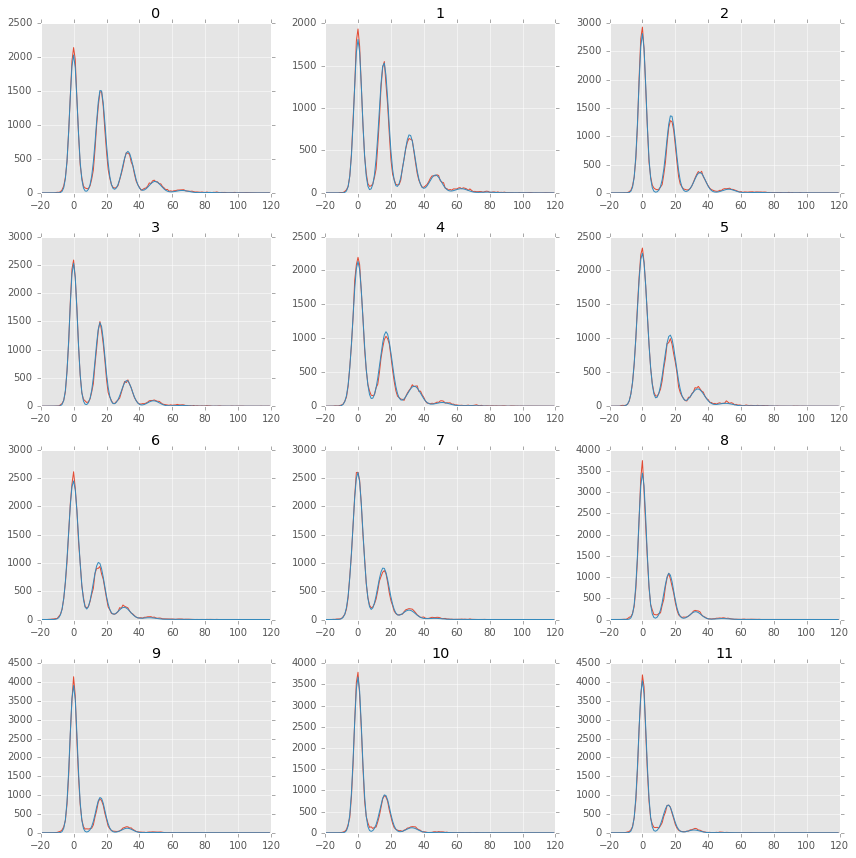

In [15]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_fits.pdf')
fun = sc.ffun_poissongauss
fig = sc.polo_cal_fit(called,indexes[:12],pss[:12],fun,xrange=(-20.,120.))
if (pdf): pdf.savefig(fig)
pdf.close()

In [16]:
pan = sc.cal_fit_poissongauss_panda(indexes, chi2, pss, covs)

In [17]:
pan[:10]

indexes  sensorID      chi2          ntot       sntot  pedestal  spedestal  \
0        0      1000  2.792219  29456.409960  299.049426 -0.035170   0.036840   
1        1      1001  2.766988  29481.405968  298.080433  0.001384   0.039118   
2        2      1002  3.918331  29268.434186  351.562906 -0.037500   0.037694   
3        3      1003  2.469873  29513.855399  280.575927 -0.074379   0.031378   
4        4      1004  2.147713  29580.686677  262.486907 -0.034178   0.037644   
5        5      1005  1.822332  29642.093868  241.775637 -0.110409   0.033976   
6        6      1006  1.549944  29685.171565  222.630061 -0.109532   0.030301   
7        7      1007  1.577486  29689.671511  224.381897 -0.132260   0.029840   
8        8      1008  3.854357  29319.728995  347.620040 -0.000509   0.034032   
9        9      1009  3.925780  29298.006152  349.894739 -0.019230   0.031715   

        gain     sgain       pes      spes     noise    snoise   noisepe  \
0  16.505100  0.039124  0.927517  0.010632  2.328638  0.029691  1.679594   
1  15.693905  0.038194  1.024539  0.011153  2.375329  0.031321  1.596361   
2  17.486753  0.053352  0.610339  0.010284  2.306387  0.029750  1.723466   
3  16.205627  0.039197  0.703341  0.008632  2.343136  0.024443  1.566446   
4  17.089615  0.054444  0.610400  0.007594  3.049506  0.029427  1.942039   
5  16.871312  0.052519  0.550854  0.006654  3.059616  0.026265  1.938697   
6  15.388966  0.050850  0.475716  0.005699  3.035009  0.023910  1.735164   
7  15.571342  0.055280  0.405899  0.005328  3.066859  0.023193  1.764258   
8  16.164404  0.065135  0.394178  0.008101  2.338449  0.026825  1.743625   
9  16.304433  0.071320  0.303280  0.007179  2.262117  0.024881  1.733020   

   snoisepe  
0  0.051276  
1  0.052123  
2  0.070012  
3  0.054517  
4  0.077919  
5  0.076389  
6  0.081580  
7  0.089783  
8  0.085174  
9  0.093621

### Saving the parameters

In [18]:
pan.to_hdf(indir+'calf_R'+irun+'_pg_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_pg_panda.csv')

### Plotting the parameters

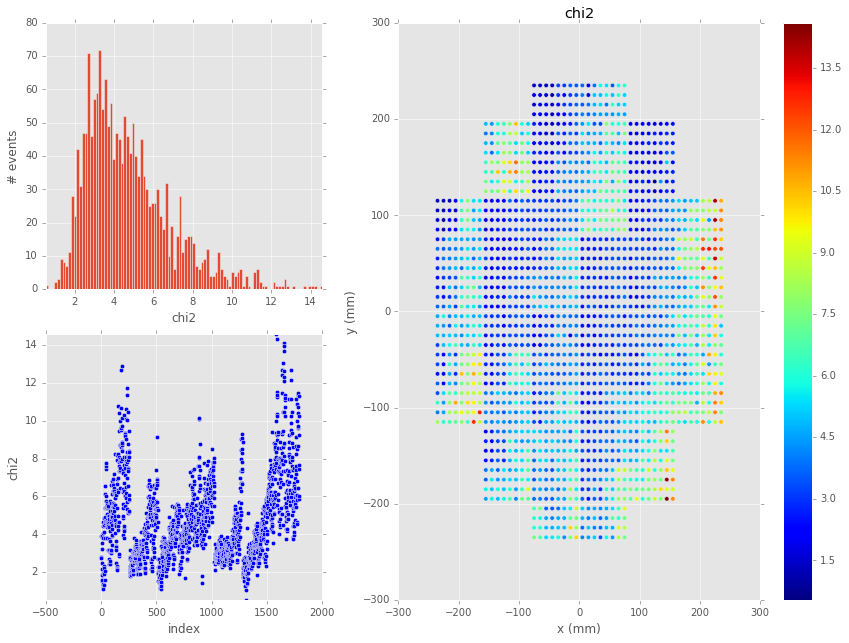

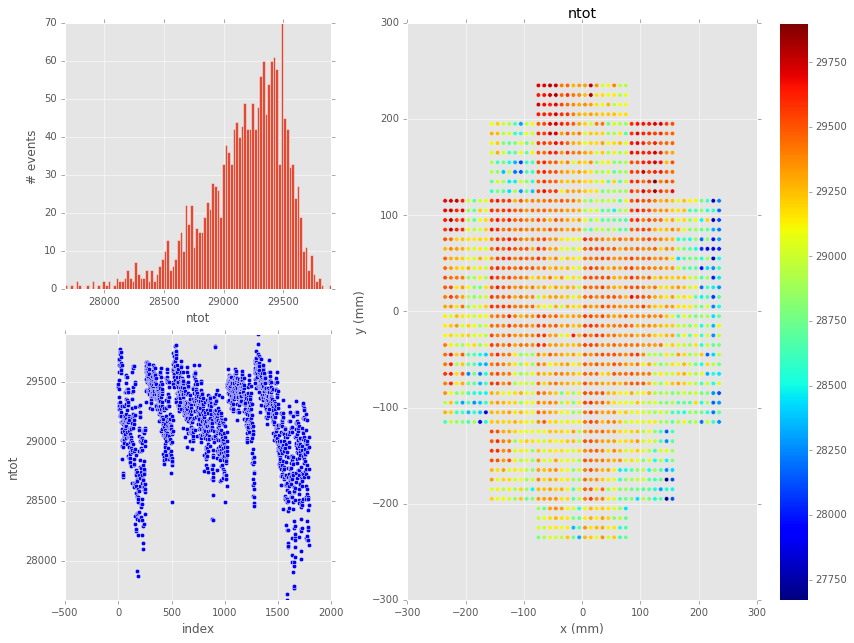

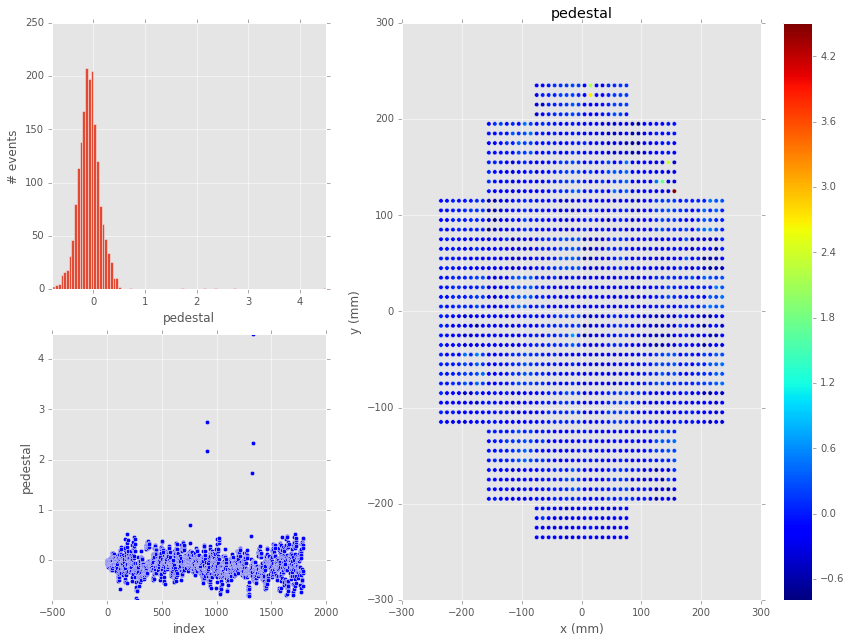

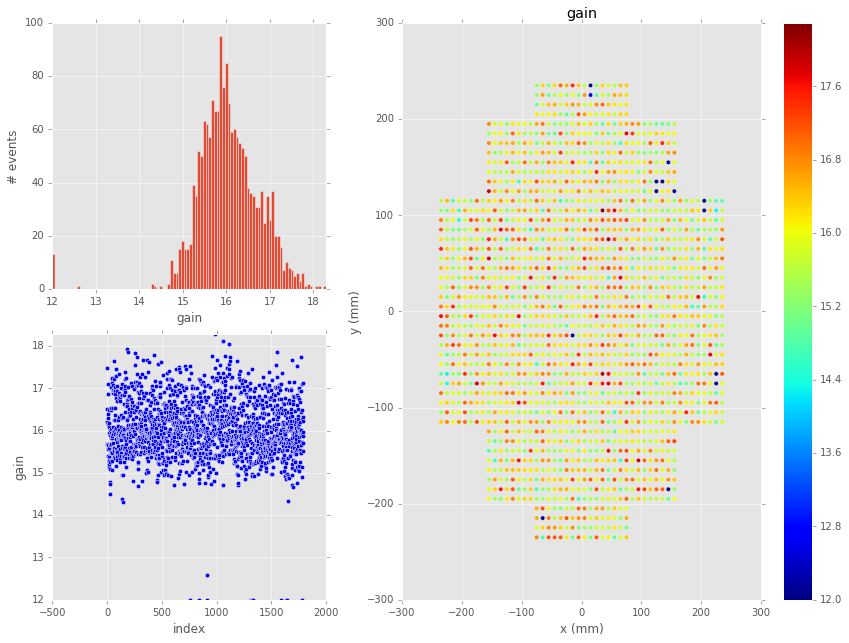

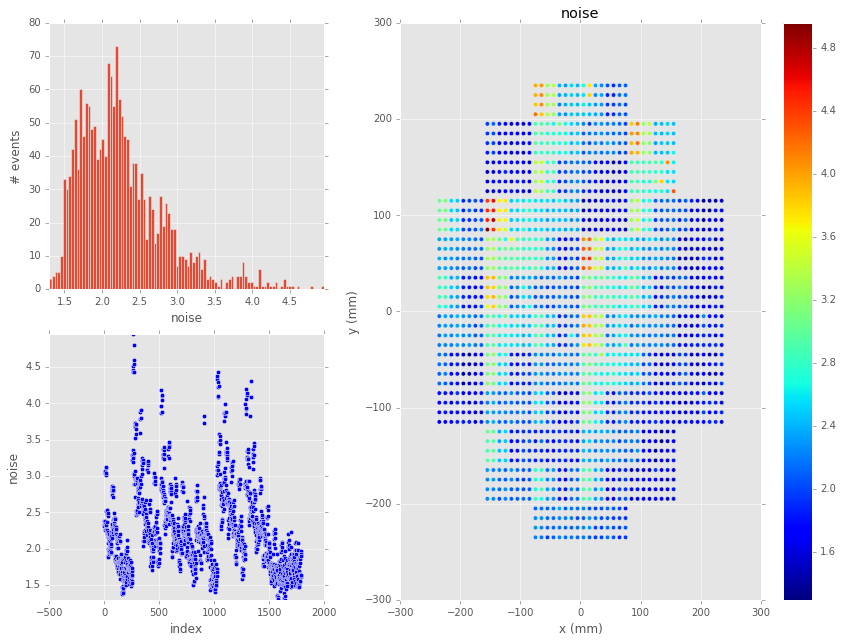

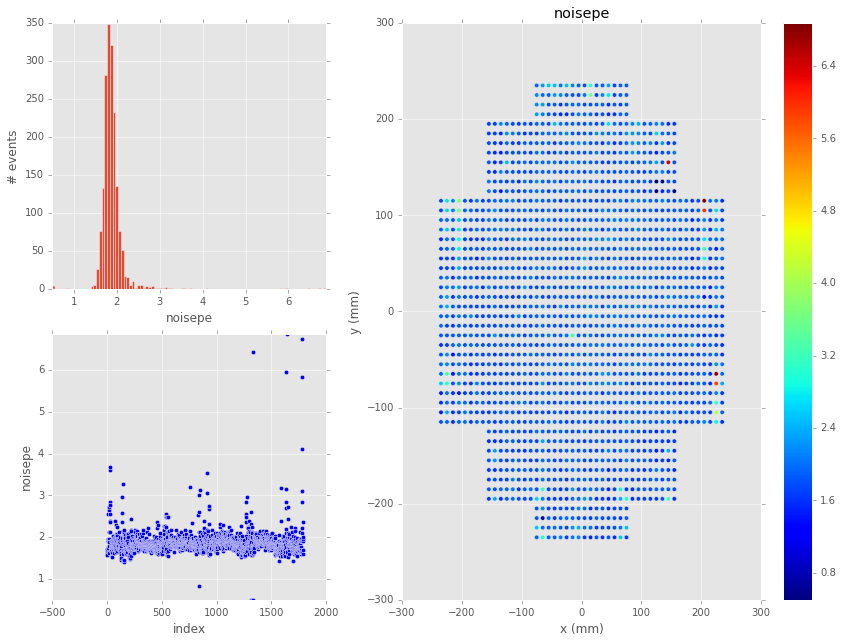

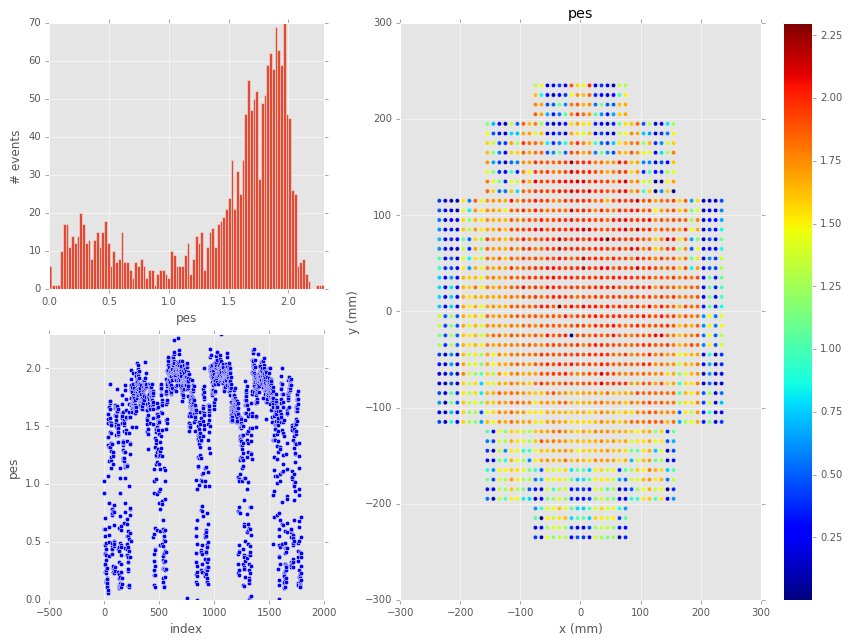

In [19]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs.pdf')
labels = ['chi2','ntot','pedestal','gain','noise','noisepe','pes']
positions = [sipm_position_of_index(ind) for ind in pan['indexes']]
for label in labels:
    fig = sc.polo_pars(pan['indexes'],pan[label],positions,label=label)
    if (pdf): pdf.savefig(fig)
pdf.close()

## Compare with the DB

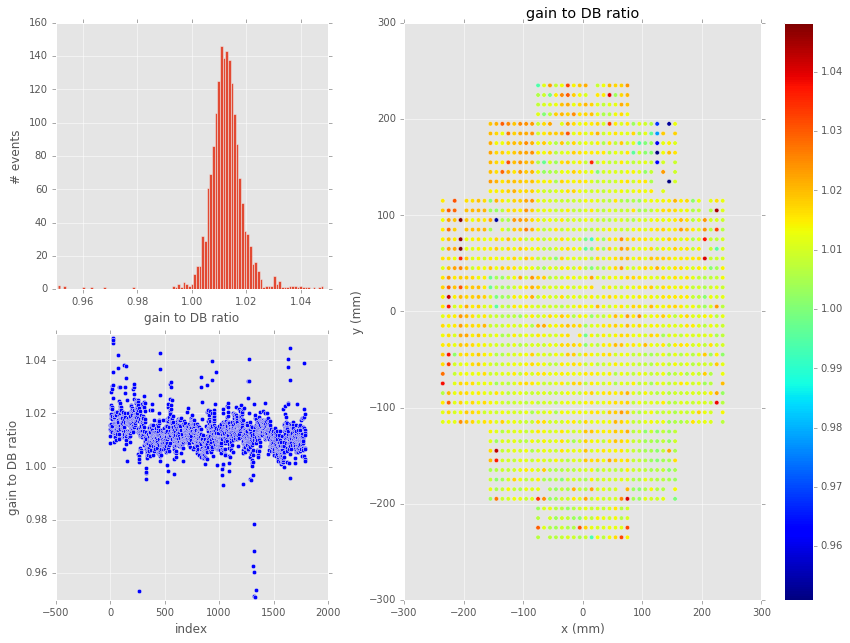

In [20]:
pdf = PdfPages(indir+'calf_R'+irun+'_compare_DB.pdf')
rat = np.array(sipmdb['adc_to_pes']/pan['gain'])
fig = sc.polo_pars(pan['indexes'], rat, positions, bins=100, label = 'gain to DB ratio', parlim=(0.95, 1.05))
if (pdf): pdf.savefig(fig)
pdf.close()

## Identify the sensors on the tails of the parameter distributions

In [21]:
zpss = zip(indexes,pss)
def pss_filter(findexes,zpss):
    ixs = list(findexes)
    fzs = filter(lambda z: z[0] in ixs,zpss)
    fpss = map(lambda z: z[1],fzs)
    return fpss

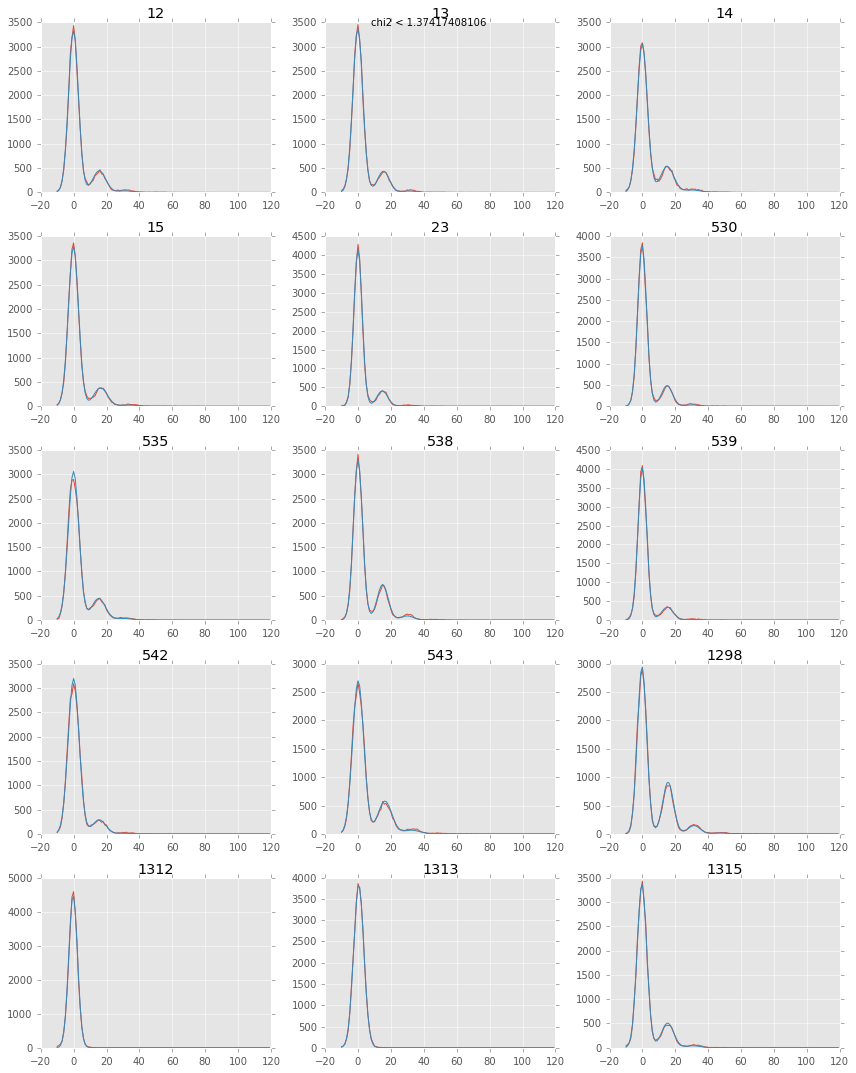

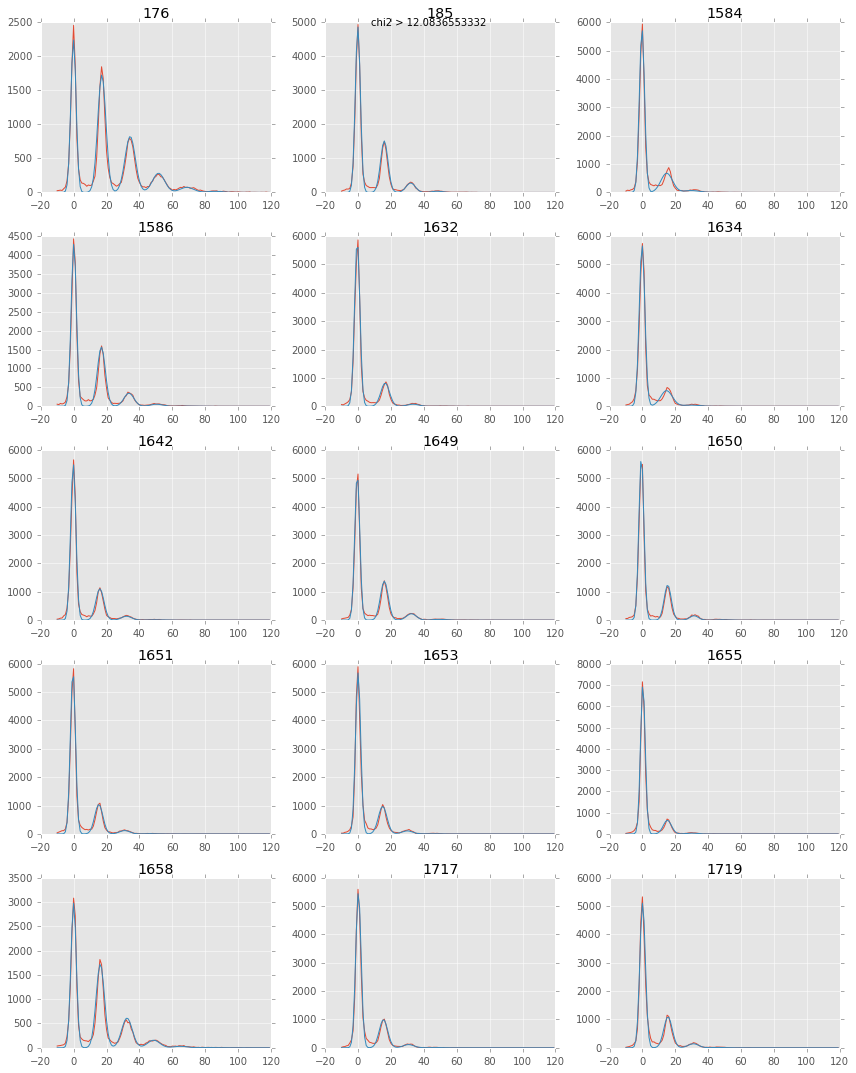

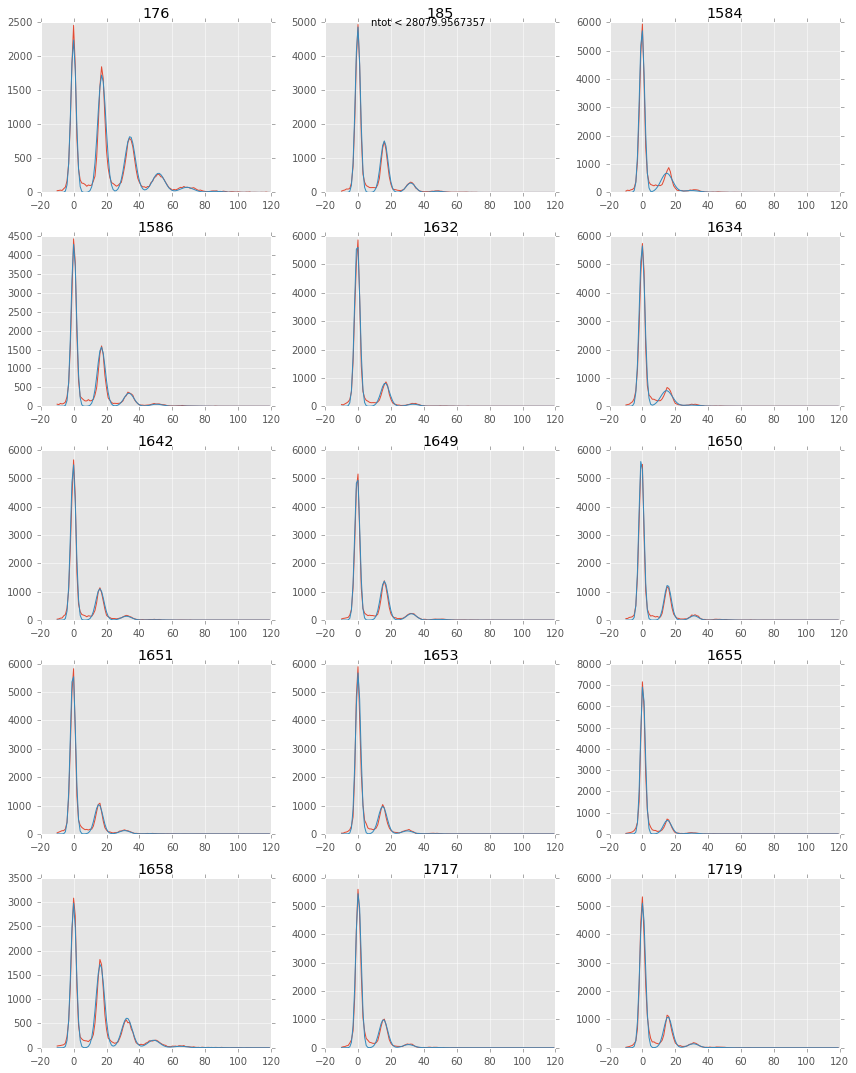

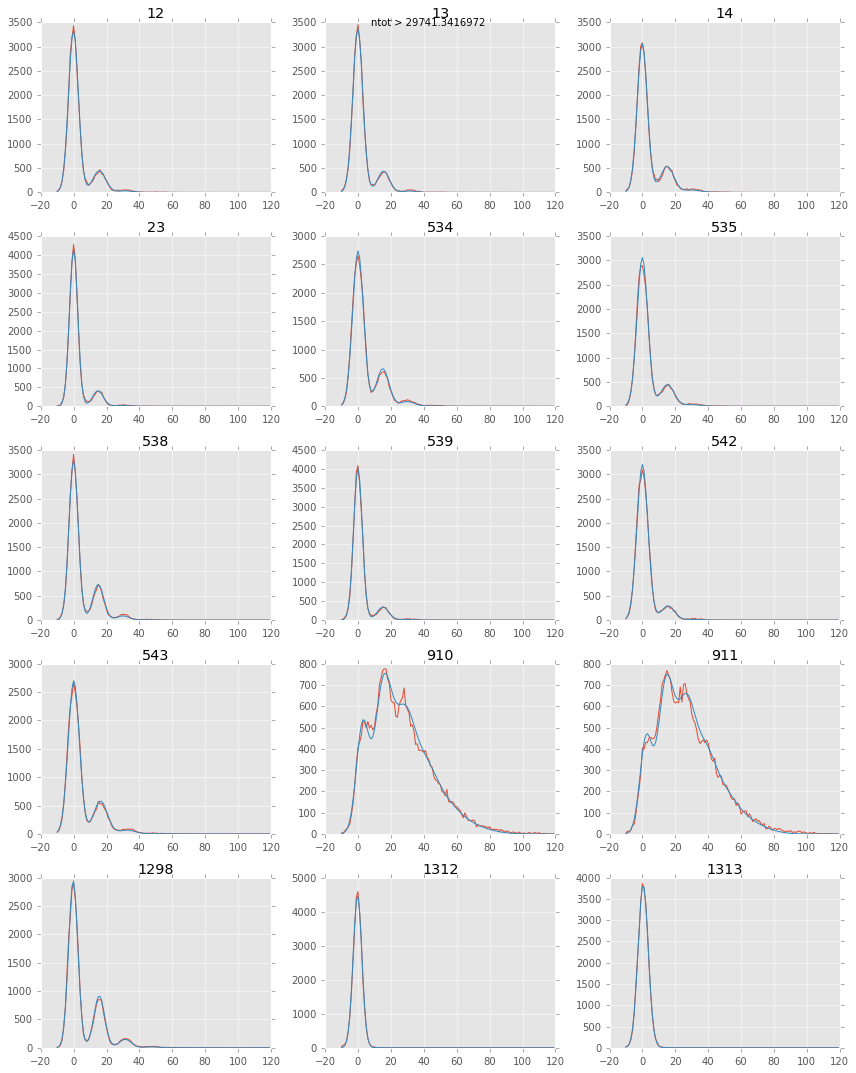

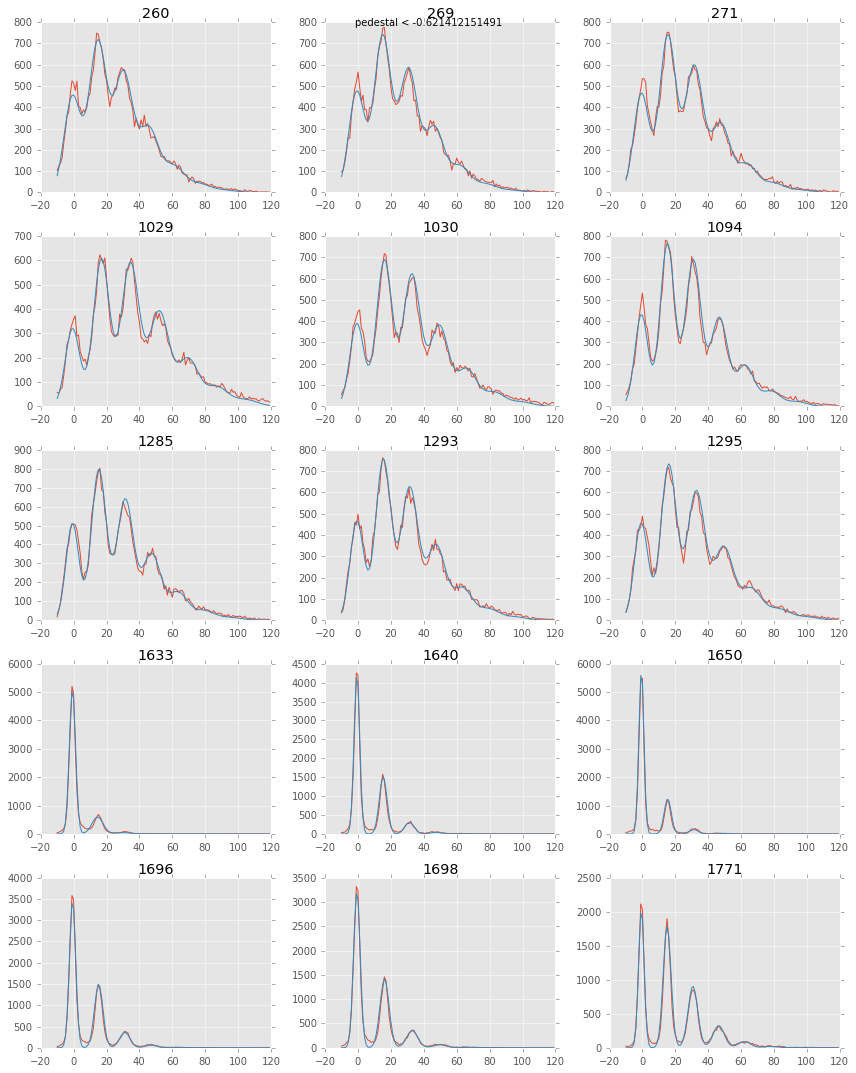

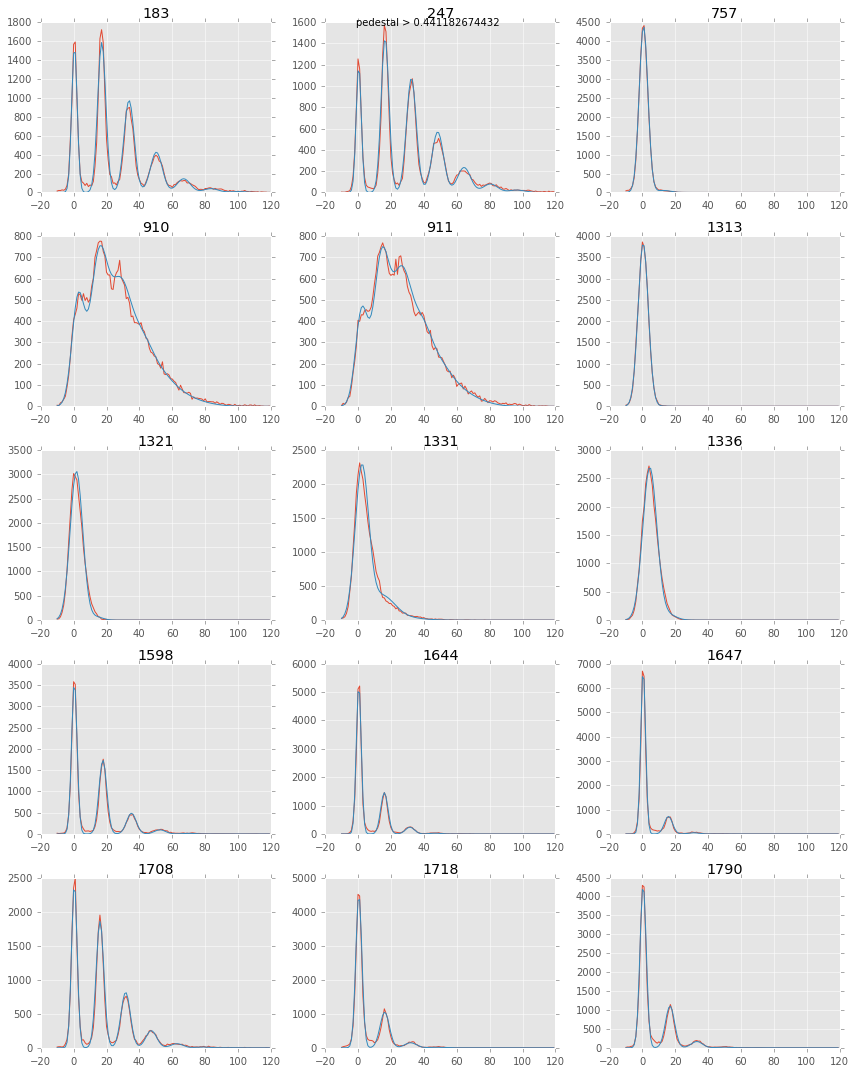

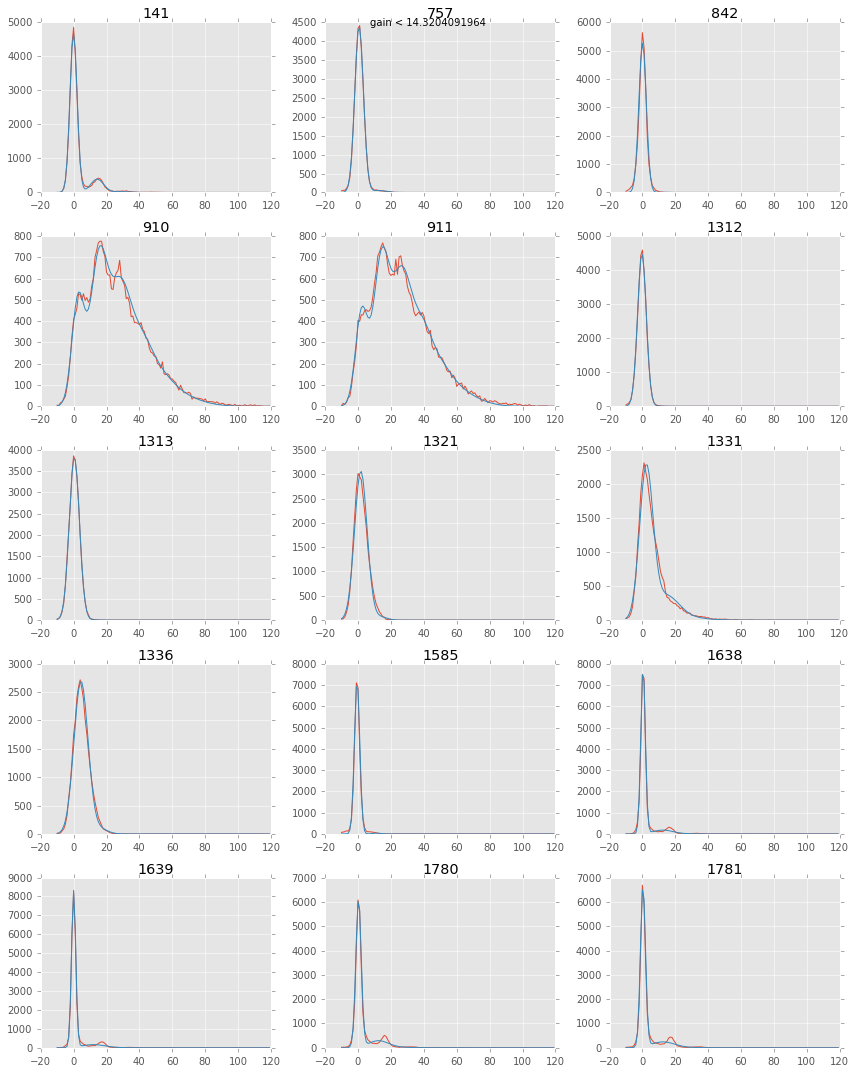

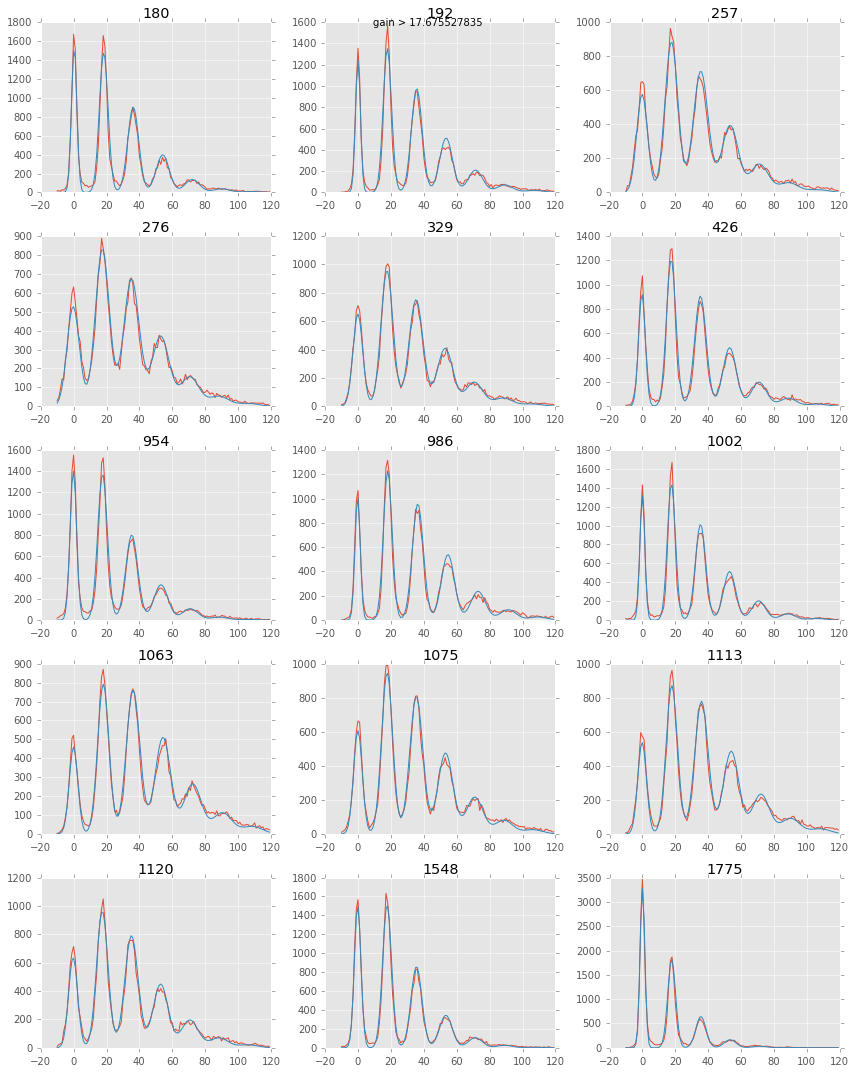

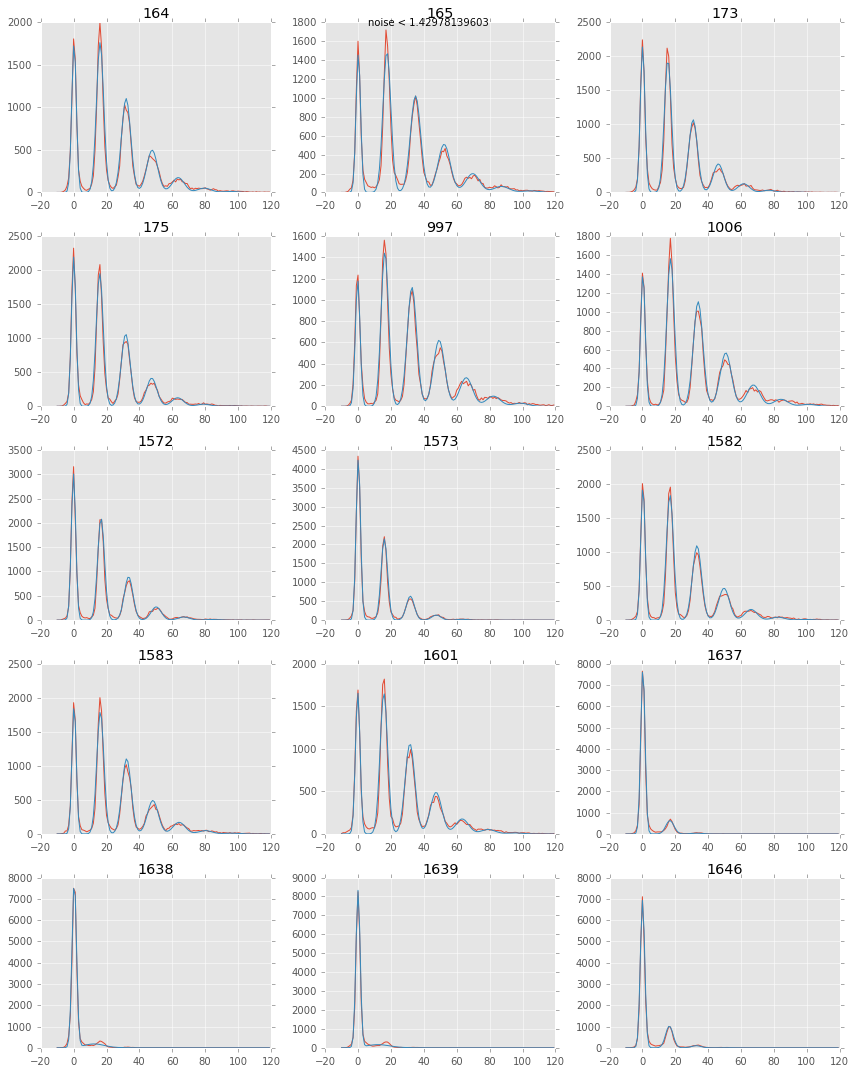

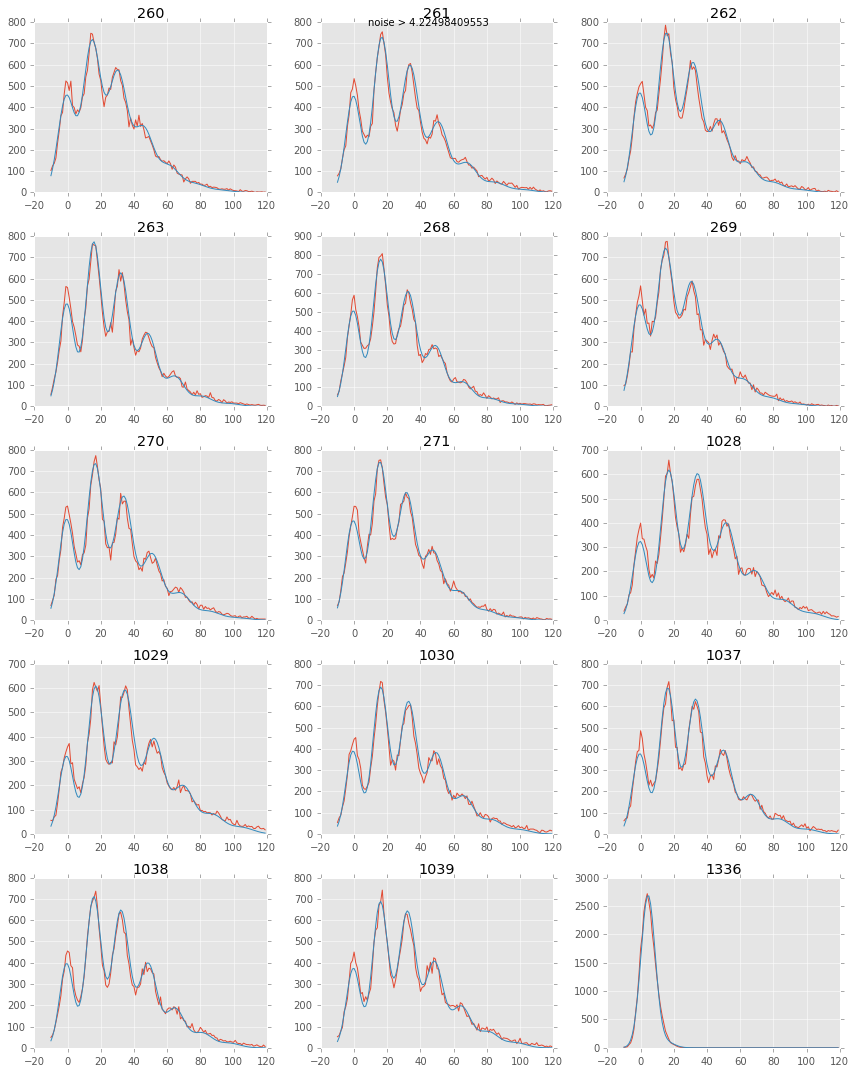

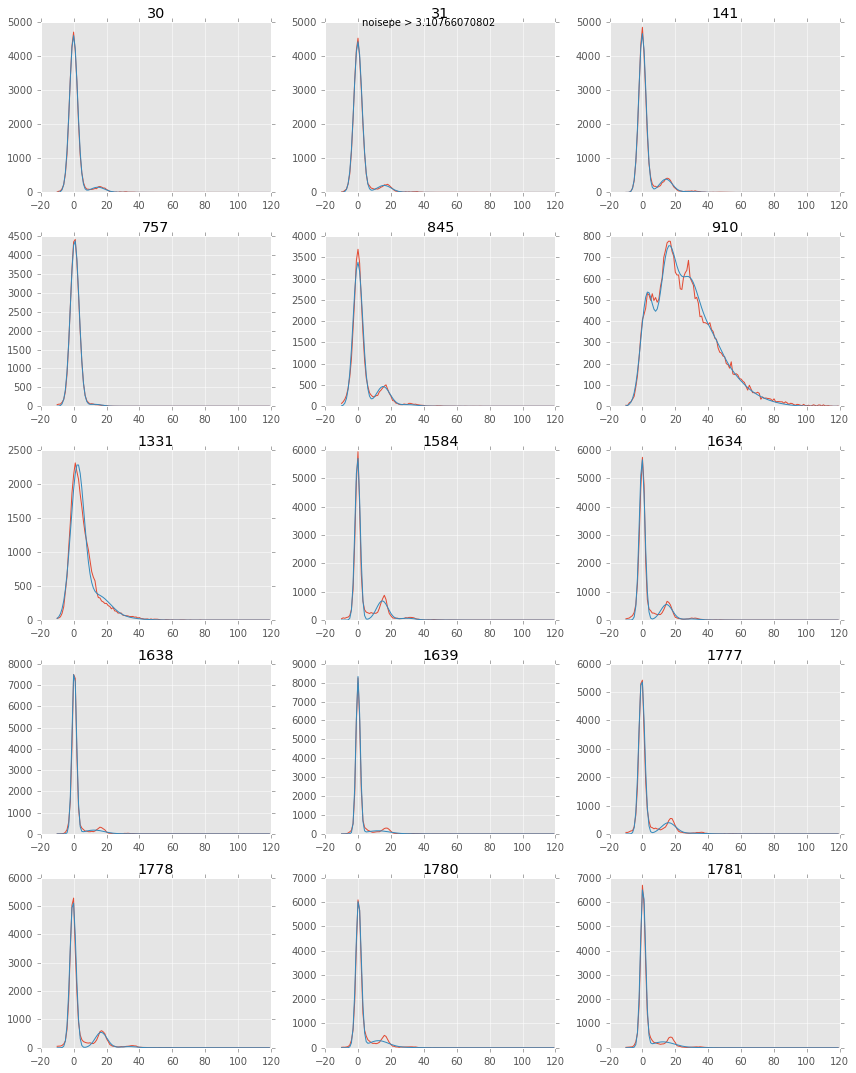

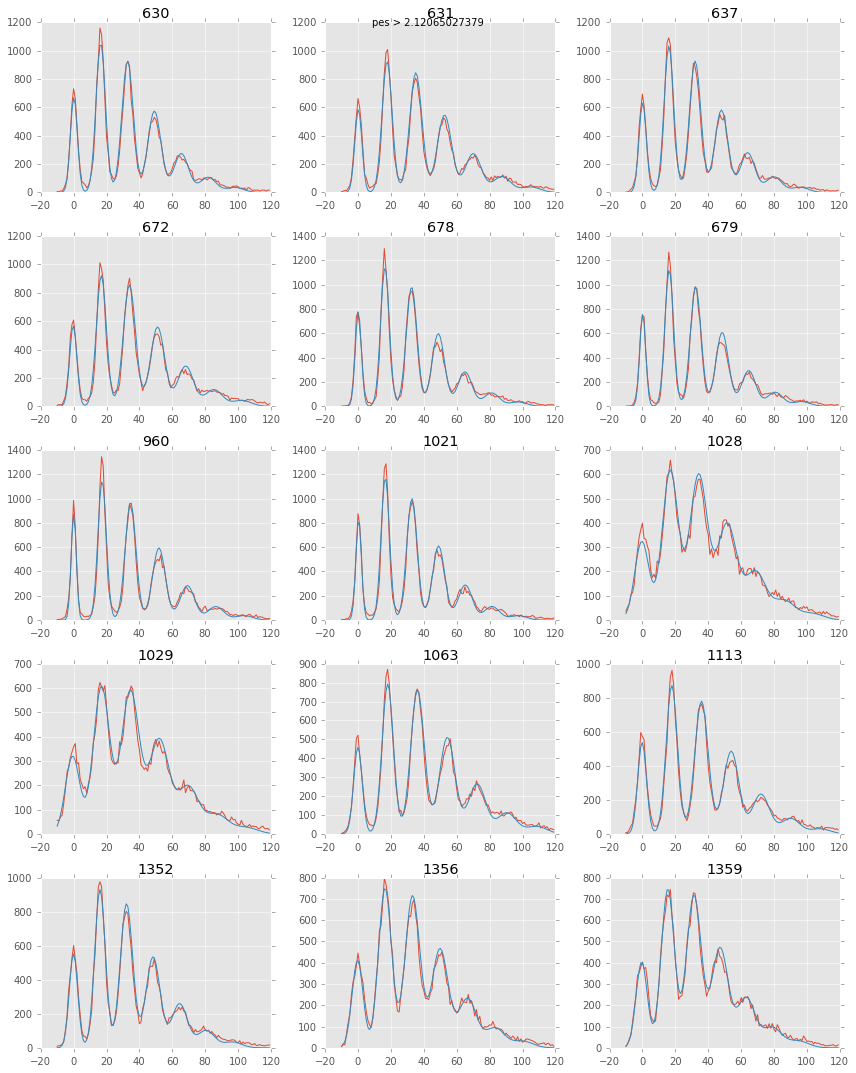

In [22]:
labels=['chi2','ntot','pedestal','gain','noise','noisepe','pes']
percentile=0.008

pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs_tails.pdf')

for label in labels:
    val0,valf = sc.np_percentile(pan[label],percentile=percentile)
    fpan = pan[pan[label]<=val0]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' < '+str(val0)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
    fpan = pan[pan[label]>=valf]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' > '+str(valf)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
        
pdf.close()
#    fpan
#    raw_input('enter key')

That's all folks!